# Загрузка библиотек

In [1]:
from copy import deepcopy
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet101
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Подготовка данных

Функция для создания набора данных

Функция считывает CSV файл и создает новый DF

In [2]:
def create_df(csv_file_path):
    data = pd.read_csv(csv_file_path)
    dfs = []
    for index, row in data.iterrows():
        img_path = row['path']
        label = row['en_name']
        df_row = pd.DataFrame({"images": [img_path], "labels": [label]})
        dfs.append(df_row)
    df = pd.concat(dfs, ignore_index=True)
    print("DataFrame created successfully:")
    print(df.head())
    return df

In [3]:
# Получение текущей директории
current_directory = os.getcwd()

# Создание пути
csv_file_path = os.path.join(current_directory, 'minerals_10_clean_updated_with_folders.csv')

# Создание DF из CSV
df = create_df(csv_file_path)

DataFrame created successfully:
                                              images       labels
0  mineral_images\hematite\ece4f566-d017-4f0d-939...     hematite
1  mineral_images\chalcedony\694ab7a9-37e8-4643-b...   chalcedony
2  mineral_images\cassiterite\8927173c-645a-4a0f-...  cassiterite
3  mineral_images\quartz\b1a450b4-3fdc-4766-945d-...       quartz
4  mineral_images\quartz\1c27ac99-2b1d-453b-89e6-...       quartz


In [4]:
# Преобразование меток в числовые занчения
le = LabelEncoder()
df["labels"] = le.fit_transform(df["labels"].values)

## Параметры обучения модели 

In [6]:
EPOCHS = 100
SIZE = 1024
LR = 1e-3 
STEP = 20
GAMMA = 0.1
BATCH = 8
NUM_CLASSES = 10

### Создание класса 

класс CloudDS наследован от класса Dataset, используется для с изображениями

In [7]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = np.array(img)
        img = self.transform(img)
        return img, label

### Трансформация изображений

Определяем два набора трансформаций изображений для использования при обучении и валидации модели машинного обучения

In [8]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((SIZE, SIZE)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Разделение данных и создание тренировочного, валидационного и тестового набора данных 

In [9]:
# Разделение на тренировочную, валидационную и тестовую выборки
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [11]:
# Создание тренировочного, валидационного и тестового наборов данных
train_ds = CloudDS(train_data, transform_train)
val_ds = CloudDS(val_data, transform_val)
test_ds = CloudDS(test_data, transform_val)

In [12]:
# Создание DataLoader для тренировочного, валидационного и тестового наборов данных
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

### Загрузка модели

In [13]:
# Загрузка предобученной модели ResNet-101
model = resnet101(pretrained=True)

C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Андюкаев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Подготовка модели для обучения

In [14]:
# Замена классификационного слоя
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

In [15]:
# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [16]:
# Перенос модели на GPU, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Обучение модели

Цикл обучения проходит на протяжении заданного количества эпох. В каждой эпохе модель обучается на тренировочной выборке и оценивается на валидационном наборе данных.
В тренировочный цикл модель переводится в режим обучения (model.train()). Затем для каждого батча тренировочной выборки выполняются следующие шаги:
- данные переносятся на GPU;
- обнуляются градиенты оптимизатора;
- выполняется прямой проход через модель;
- вычисление потерь (loss);
- градиенты вычисляются с помощью обратного распространения ошибки;
- обновление параметров модели с помощью оптимизатора;
- расчет общей потери и точности для текущей эпохи.
После завершения обучения модель переводится в режим оценки (model.eval()). Затем для каждого батча валидационного набора выполняются аналогичные шаги что и для тренировочной выборки, кроме обратного распространения ошибки и обновления параметров модели.

In [18]:
# Установка переменной окружения CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

best_model = deepcopy(model.state_dict())
best_acc = 0.0
train_best = 0.0

loss_train = []
acc_train = []

loss_val = []
acc_val = []

for i in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    for img, target in train_dl:
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, target.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        train_total += target.size(0)
        train_acc += (predicted == target).sum().item()
        
    train_loss /= len(train_dl)
    train_acc /= train_total
    
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for img, target in val_dl:
            img, target = img.to(device), target.to(device)
            out = model(img)
            loss = criterion(out, target.long())
            val_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            val_total += target.size(0)
            val_acc += (predicted == target).sum().item()
            
    val_loss /= len(val_dl)
    val_acc /= val_total
    
    if val_acc >= best_acc and train_acc >= train_best:
        best_acc = val_acc
        train_best = train_acc
        best_model = model.state_dict()
        
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    
    # Сохраняем результаты работы модели
    torch.save(model.state_dict(), 'resnet101_epoch_adam_{}.pt'.format(i))

    # Сохраняем лучшую модель
    best_model_path = 'best_model_resnet101.pt'
    torch.save(best_model, best_model_path)
    
    print("Epoch {} train loss {:.4f} acc {:.4f} val loss {:.4f} acc {:.4f}".format(i, train_loss, train_acc,
                                                                                      val_loss, val_acc))
    
    # Очистка кэша GPU
    torch.cuda.empty_cache()

Epoch 1 train loss 1.6154 acc 0.4612 val loss 1.2160 acc 0.5888
Epoch 2 train loss 1.2447 acc 0.5848 val loss 1.1108 acc 0.6336
Epoch 3 train loss 1.1291 acc 0.6145 val loss 0.8597 acc 0.7405
Epoch 4 train loss 1.0272 acc 0.6495 val loss 0.8589 acc 0.6819
Epoch 5 train loss 0.9924 acc 0.6654 val loss 0.9244 acc 0.6759
Epoch 6 train loss 0.9896 acc 0.6711 val loss 0.8941 acc 0.7034
Epoch 7 train loss 0.9230 acc 0.6885 val loss 0.8267 acc 0.6983
Epoch 8 train loss 0.8950 acc 0.6959 val loss 0.7616 acc 0.7543
Epoch 9 train loss 0.8683 acc 0.7066 val loss 0.7017 acc 0.7698
Epoch 10 train loss 0.8546 acc 0.7099 val loss 0.8492 acc 0.7500
Epoch 11 train loss 0.8717 acc 0.7144 val loss 0.6992 acc 0.7664
Epoch 12 train loss 0.8592 acc 0.7114 val loss 0.8099 acc 0.7440
Epoch 13 train loss 0.8308 acc 0.7243 val loss 0.7163 acc 0.7543
Epoch 14 train loss 0.8288 acc 0.7174 val loss 0.7185 acc 0.7638
Epoch 15 train loss 0.8476 acc 0.7202 val loss 0.9470 acc 0.6922
Epoch 16 train loss 0.8354 acc 0.7

In [21]:
# Загрузка последней сохраненной модели.
# model.load_state_dict(torch.load('resnet101_epoch_adam_35.pt'))

<All keys matched successfully>

# Сохрание результатов обучения

In [19]:
# Сохранение значений loss и accuracy
with open('loss_train_101.pkl', 'wb') as f:
    pickle.dump(loss_train, f)

with open('acc_train_101.pkl', 'wb') as f:
    pickle.dump(acc_train, f)

with open('loss_val_101.pkl', 'wb') as f:
    pickle.dump(loss_val, f)

with open('acc_val_101.pkl', 'wb') as f:
    pickle.dump(acc_val, f)

# Сохранение лучшей модели в формате pkl
with open('best_model_101.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Визуализация потерь и точности модели

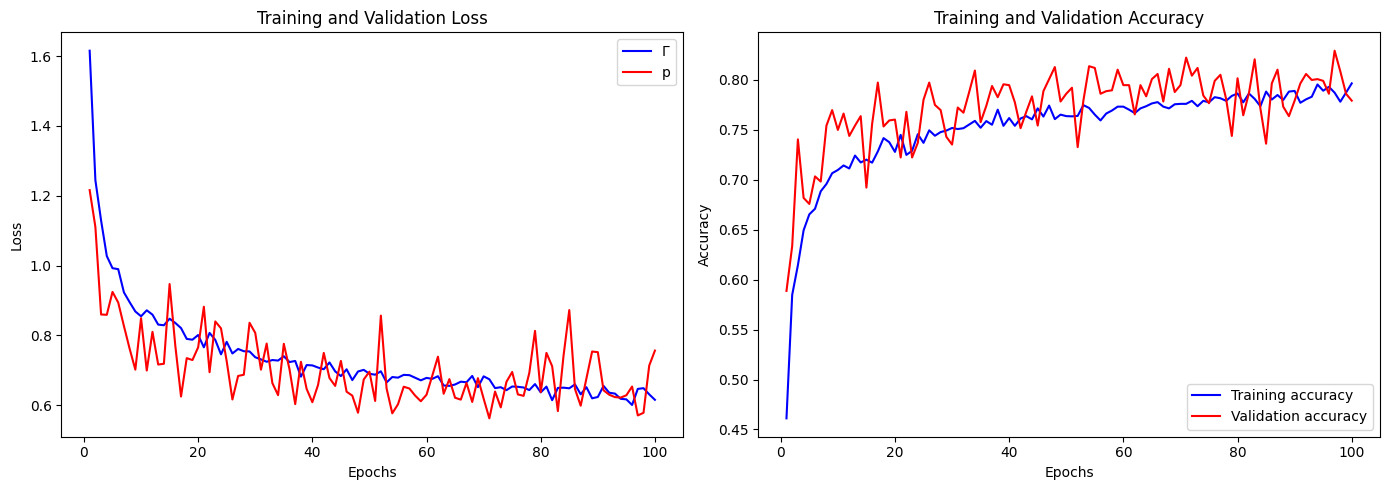

In [20]:
def plot_results(loss_train, loss_val, acc_train, acc_val):
    epochs = range(1, len(loss_train) + 1)

    plt.figure(figsize=(14, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_train, 'b', label='Training loss')
    plt.plot(epochs, loss_val, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend('График потерь')

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_train, 'b', label='Training accuracy')
    plt.plot(epochs, acc_val, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show('График точности')

# Визуализация результатов
plot_results(loss_train, loss_val, acc_train, acc_val)

На графиках видно, что потери за 100 эпох значительно уменьшились, а точность значительно возросла. Но модельне не вышла на плато, что говорит о не достаточности эпох обучения. Видно, что петери больше чем у предыдушей модели, это объясняется тем, что архитектура более глубокая. 

# Тестирование модели

### Создание функции predict 

Эта функция предсказывает классы изображения с использованием обученной модели

In [24]:
def predict(img_dir):
    img = np.array(Image.open(img_dir))
    img = transform_val(img)
    img = img.view([1, 3, SIZE, SIZE])
    if torch.cuda.is_available():
        img = img.cuda()
    model.load_state_dict(best_model)  # Load the best model state dictionary
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        out = model(img)
        
    return out.argmax(1).item()


### Создадим списки с предсказанными метками и истинными метками

In [25]:
# Списки для хранения предсказанных и истинных меток
predictions = []
truth = []

# Итерируем по всем элементам в тестовом наборе данных
for i in range(len(test_data)):
    # Получаем путь к изображению из тестового набора данных
    img_path = test_data.iloc[i, 0]
    # Предсказываем класс для текущего изображения и добавляем его в список предсказаний
    predictions += [predict(img_path)]
    # Получаем истинную метку для текущего изображения и добавляем её в список истинных меток
    truth += [test_data.iloc[i, -1]]

### Вывод метрик

Score is: 75.24%
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       100
           1       0.77      0.86      0.81        94
           2       0.64      0.19      0.30        72
           3       0.86      0.79      0.82       121
           4       0.75      0.33      0.46       142
           5       0.78      0.90      0.83        81
           6       0.46      0.92      0.61       129
           7       0.78      0.67      0.72       103
           8       0.80      0.86      0.83       425
           9       0.95      0.89      0.92       183

    accuracy                           0.75      1450
   macro avg       0.76      0.70      0.70      1450
weighted avg       0.78      0.75      0.74      1450



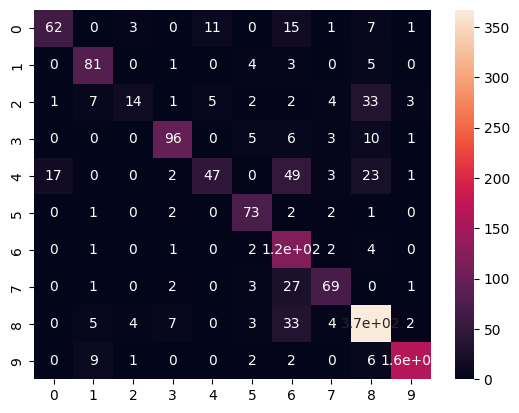

In [26]:
score = accuracy_score(truth, predictions)
cm = confusion_matrix(truth, predictions)
report = classification_report(truth, predictions)
print("Score is: {}%".format(round(score*100, 2)))
print(report)
sns.heatmap(cm, annot=True)
plt.show()

### Создадим функцию для извлечения признаков

In [36]:
# Извлечение векторов признаков из модели
def extract_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.extend(targets.numpy())
    features = np.concatenate(features)
    return features, labels

# Извлечение признаков из тестового набора
test_features, test_labels = extract_features(test_dl, model)


## Применение t-SNE для уменьшения размерностей и визуализация признаков

### Уменьшение размерностей с применением t-SNE

In [37]:
# Уменьшим размерность с t-SNE
tsne = TSNE(n_components=2, random_state=42)
test_embeddings = tsne.fit_transform(test_features)

### Визуализация признаков 2D

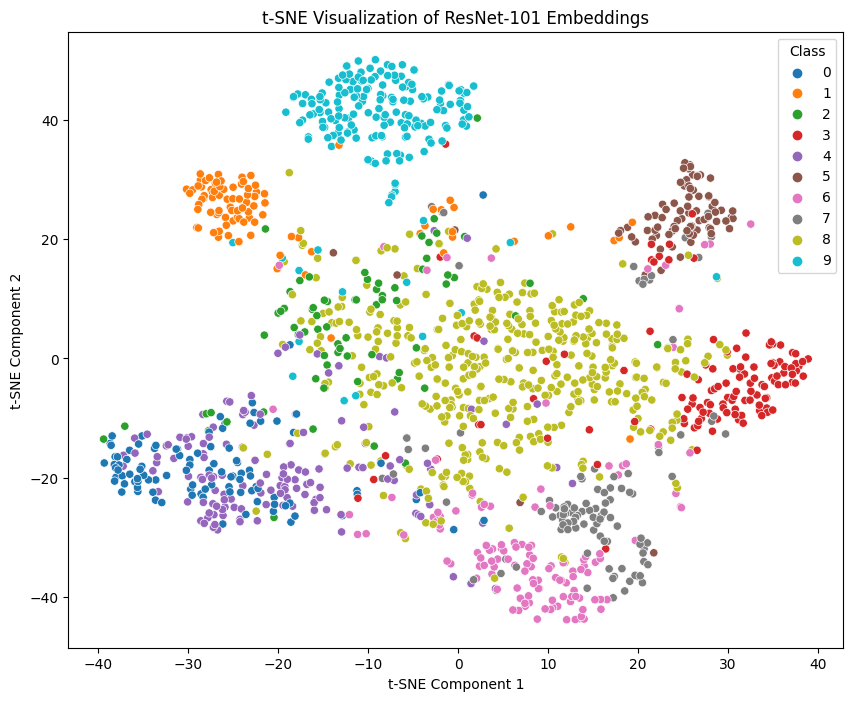

In [38]:
# Visualize t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_embeddings[:,0], y=test_embeddings[:,1], hue=test_labels, palette='tab10', legend='full')
plt.title('t-SNE Visualization of ResNet-101 Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()

На скатерограмме видно, что признаки хорошо разделены, но есть наложения, что говорит о недостатке обучения. Если сравнить с ResNet50 то разделение произошло лучше

### Уменьшение размерностей с применением t-SNE до 3D

In [40]:
# Уменьшим размерность с t-SNE до 3D
tsne_3d = TSNE(n_components=3, random_state=42)
test_embeddings_3d = tsne_3d.fit_transform(test_features)

### Визуализация признаков в 3D

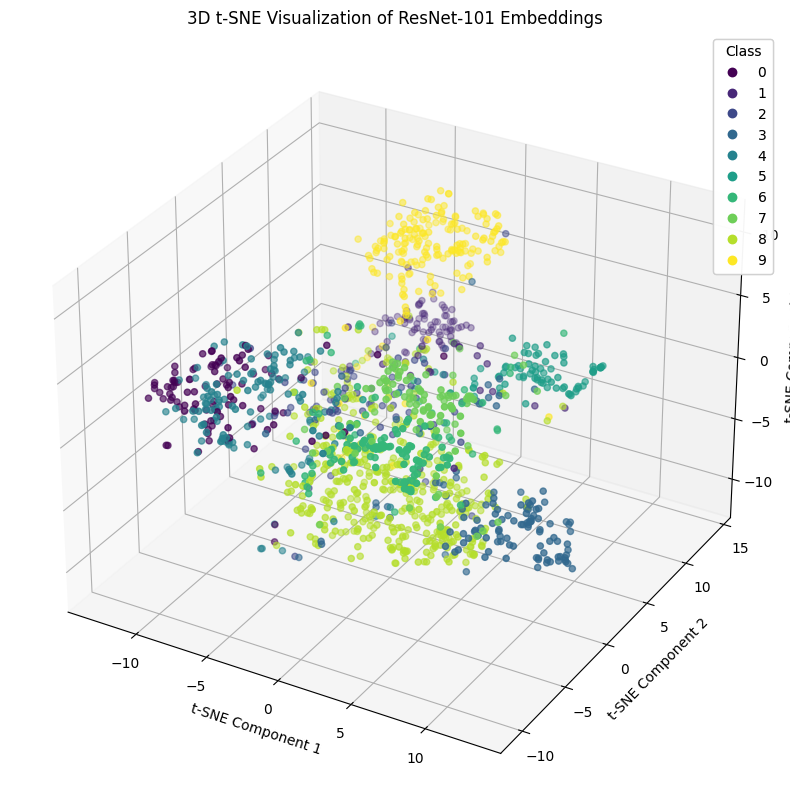

In [41]:
# Визуализация признаков t-SNE в 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(test_embeddings_3d[:, 0], test_embeddings_3d[:, 1], test_embeddings_3d[:, 2], c=test_labels, cmap='viridis')
ax.set_title('3D t-SNE Visualization of ResNet-101 Embeddings')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
legend = ax.legend(*scatter.legend_elements(), title='Class', loc='upper right')
ax.add_artist(legend)
plt.show()

Здесь так же видно, что признаки разделены, но есть наложения.

## Применение метода k-ближайших сосдей

### Создание функции для поиска ближайших соседей

In [51]:
# Функция для поиска ближайших соседей для каждой точки
def find_nearest_neighbors(embeddings, k):
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    return distances, indices

# Поиск ближайших соседей top-k для каждой точки
k_neighbors = 3  # Определите количество соседей для поиска
distances, indices = find_nearest_neighbors(test_embeddings, k_neighbors)

### Создание функции для вычисления метрики

In [52]:
# Функция для вычисления метрики top-k
def calculate_topk_metrics(labels, indices, k):
    correct = 0
    total = len(labels)
    for i, idx_list in enumerate(indices):
        for idx in idx_list[1:k]:  # Исключение первого индекса (который является самой точкой)
            if labels[i] == labels[idx]:
                correct += 1
                break
    topk_accuracy = correct / total
    return topk_accuracy


### Вывод метрики

In [53]:
# Поиск ближайших соседей top-k для каждой точки в тестовом наборе
distances_test, indices_test = find_nearest_neighbors(test_features, k_neighbors)

# Вычисление точности top-k для тестового набора
topk_accuracy_test = calculate_topk_metrics(test_labels, indices_test, k_neighbors)
print("Top-{} Accuracy for Test Set: {:.2f}%".format(k_neighbors, topk_accuracy_test * 100))

Top-3 Accuracy for Test Set: 83.93%


Точность можно улучшить увеличением эпох обучения.